In [1]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import datasets
from tqdm import tqdm
os.chdir('../src')

from models.diffusion import Diffusion, CondDiffusion
from models.adversary import Adversary, ConditionalAdversary, GuidedAdversary
from models.guidance import Guidance
from models.unet import Unet
from models.condunet import condUnet

reverse_transform = transforms.Compose([transforms.Lambda(lambda x: (x+1)/2), transforms.ToPILImage()])


/home/tristan/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs('../data/CIFAR10', exist_ok=True)

dataset_train = datasets.CIFAR10(
        root='../data/CIFAR10',
        train=True,
        download=True,
        transform=transforms.Compose([transforms.Grayscale(), transforms.CenterCrop(28),transforms.ToTensor()])
    )

Files already downloaded and verified


In [ ]:
##### Unconditional Diffusion #####

model_path = '../outputs/models/fashion_mnist_diffusion_epoch_19.pt'
# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = Unet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
)
net.load_state_dict(torch.load(model_path))

fashion_mnist_diffusion = Diffusion(
    model=net,
    data_shape=data_shape,
    noise_schedule='linear',
    T=T,
    device=device,
)

In [ ]:
# construct the adversary
adversary = Adversary(
    data_shape=data_shape,
    diffusion_model=fashion_mnist_diffusion,
    device=device,
)

In [ ]:
# sample unperturbed image from the adversary
x = adversary.sample()
plt.imshow(reverse_transform(x[0].cpu()), cmap='gray')

In [ ]:
# sample gaussian perturbed image from the adversary
perturbed_sample, original_sample = adversary.gaussian_perturb(t=150)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [ ]:
adversarial_target = next(iter(dataset_train))[0].unsqueeze(0).to(device)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_perturb(t=150, target=adversarial_target)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [ ]:
adversarial_target = next(iter(dataset_train))[0].unsqueeze(0).to(device)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_descent_perturb(t=50, target=adversarial_target, scale=5)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [ ]:
##### Conditional Diffusion #####

model_path = '../outputs/models/cond_fashion_mnist_diffusion_linear_sched_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=10,
)
net.load_state_dict(torch.load(model_path))

fashion_mnist_cond_diffusion = CondDiffusion(
    model=net,
    data_shape=data_shape,
    noise_schedule='linear',
    T=T,
    device=device,
)

In [ ]:
# construct the adversary
adversary = ConditionalAdversary(
    data_shape=data_shape,
    diffusion_model=fashion_mnist_cond_diffusion,
    device=device,
)

In [ ]:
# sample unperturbed image from the adversary
y = torch.tensor([0]).to(device)
y_adv = torch.tensor([1]).to(device)
x = adversary.sample(y)
plt.imshow(reverse_transform(x[0].cpu()), cmap='gray')

In [ ]:
# sample gaussian perturbed image from the adversary
perturbed_sample, original_sample = adversary.gaussian_perturb(t=150, y=y)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [ ]:
adversarial_target = adversary.sample(y_adv)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_perturb(t=150, target=adversarial_target, y=y)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [ ]:
adversarial_target = adversary.sample(y_adv)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_descent_perturb(t=50, target=adversarial_target, scale=5, y=y)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

In [6]:
##### Guided Diffusion #####
model_path = '../outputs/models/guided_fashion_mnist_diffusion_epoch_19.pt'

# model params
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

unet = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=11,
)
unet.load_state_dict(torch.load(model_path))

guided_diffusion = Guidance(
    model=unet,
    data_shape=data_shape,
    T=T,
    device=device,
    noise_schedule='linear'
)

In [7]:
# construct the adversary
adversary = GuidedAdversary(
    data_shape=data_shape,
    diffusion_model=guided_diffusion,
    device=device,
)

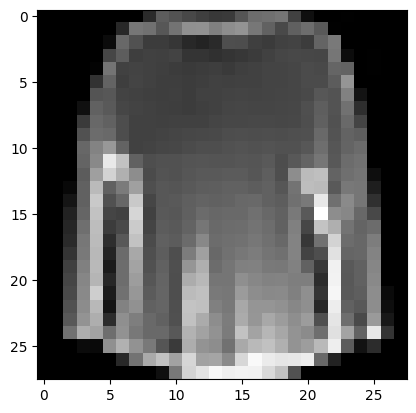

In [8]:
# sample unperturbed image from the adversary
y = torch.tensor([0]).to(device)
w = 1
y_adv = torch.tensor([1]).to(device)
x = adversary.sample(y, w)
plt.imshow(reverse_transform(x[0].cpu()), cmap='gray')

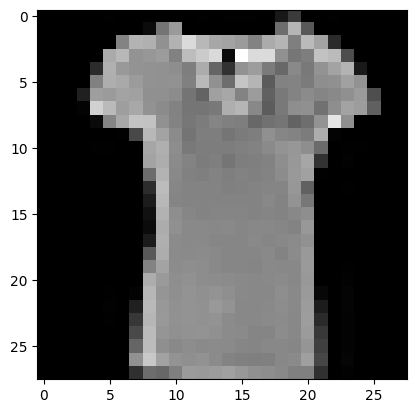

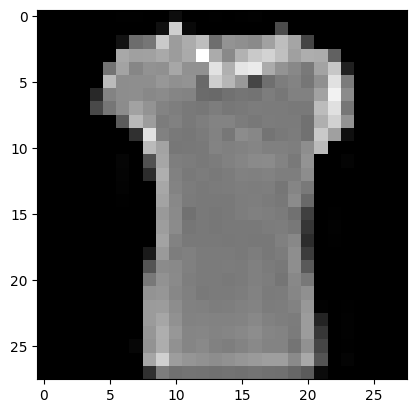

In [9]:
# sample gaussian perturbed image from the adversary
perturbed_sample, original_sample = adversary.gaussian_perturb(t=150, y=y, w=w)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

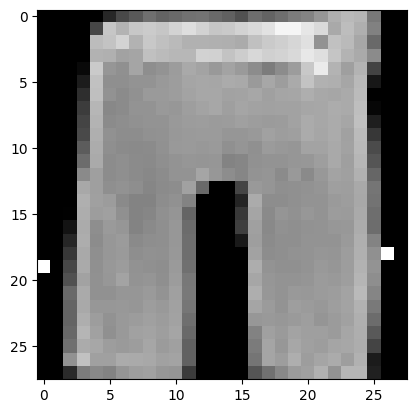

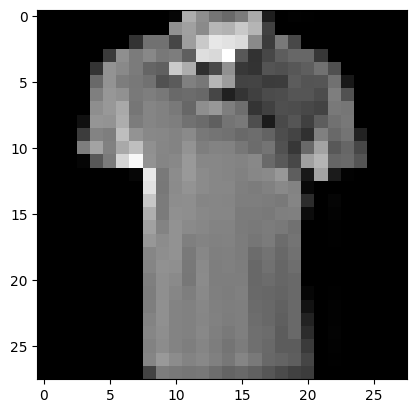

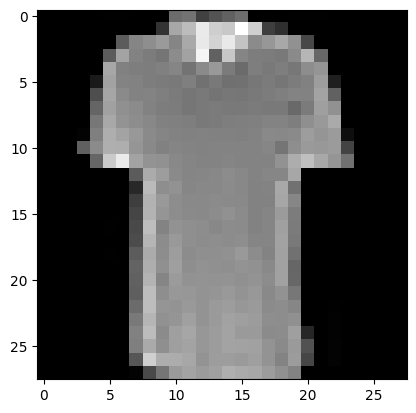

In [10]:
adversarial_target = adversary.sample(y_adv, w=w)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_perturb(t=150, target=adversarial_target, y=y, w=w)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')

Adversarial loss: 26.143688201904297
Adversarial loss: 22.1247501373291
Adversarial loss: 18.335439682006836
Adversarial loss: 14.69870662689209
Adversarial loss: 10.195266723632812
Adversarial loss: 5.160912036895752
Adversarial loss: 3.079972267150879
Adversarial loss: 2.4823145866394043
Adversarial loss: 3.9379026889801025
Adversarial loss: 2.726801633834839
Adversarial loss: 3.82985258102417
Adversarial loss: 2.8861098289489746
Adversarial loss: 3.1408324241638184
Adversarial loss: 3.162792205810547
Adversarial loss: 3.481171131134033


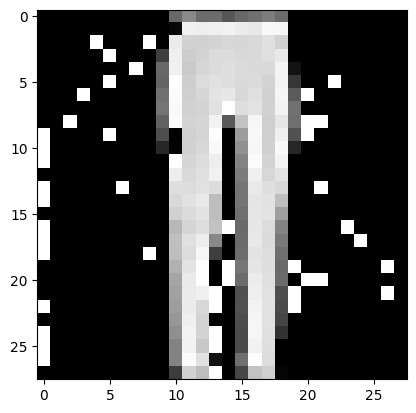

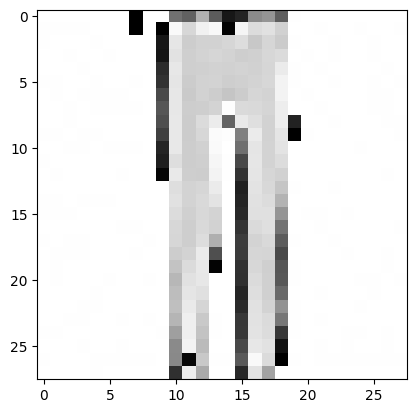

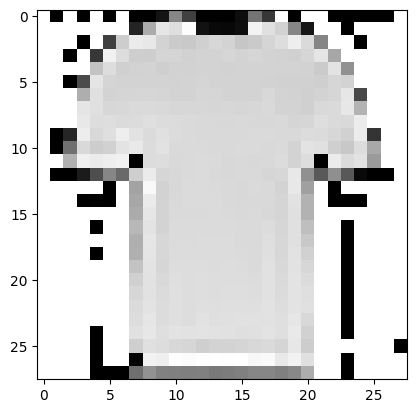

In [12]:
adversarial_target = adversary.sample(y_adv, w=w)
plt.figure()
plt.imshow(reverse_transform(adversarial_target[0].cpu()), cmap='gray')
perturbed_sample, original_sample = adversary.gradient_descent_perturb(t=50, target=adversarial_target, scale=5, y=y, w=w)
plt.figure()
plt.imshow(reverse_transform(perturbed_sample[0].cpu()), cmap='gray')
plt.figure()
plt.imshow(reverse_transform(original_sample[0].cpu()), cmap='gray')